In [1]:
import glob
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from tqdm import tqdm

geolocator = Nominatim(timeout=500, user_agent="myapplication")
eps = np.finfo(np.float64).eps

In [2]:
data_dir = "../downloaded_files/"
files = glob.glob(f"{data_dir}*.csv")

flood_columns = list(pd.read_csv(files[0]).columns)
flood_df = pd.DataFrame(columns=flood_columns)

for file in tqdm(files, desc="Concating dataframes", unit="file"):
    df = pd.read_csv(file)
    flood_df = pd.concat([flood_df, df])


flood_df.sort_values(
    ["Admin3", "Start_Date", "End_Date", "Flooded_Area_SqKM"],
    ascending=[True, True, True, False],
    inplace=True,
)
flood_df = flood_df.reset_index(drop=True)
flood_df.to_csv("flood_data.csv", index=False)
flood_df.head()

Concating dataframes:   0%|          | 0/1225 [00:00<?, ?file/s]/tmp/ipykernel_5641/2613968224.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flood_df = pd.concat([flood_df, df])
Concating dataframes: 100%|██████████| 1225/1225 [00:39<00:00, 31.18file/s]


,Admin3,Admin2,Admin1,Observed_Area_SqKM,Flooded_Area_SqKM,Population_Exposed,Flooded Crop Area,Start_Date,End_Date
0,Ahlone,Yangon (West),Yangon,3.78,0.0,0,0.0,2024-07-01,2024-07-06
1,Ahlone,Yangon (West),Yangon,3.78,0.0,0,0.0,2024-07-01,2024-07-08
2,Ahlone,Yangon (West),Yangon,3.78,0.0,0,0.0,2024-07-01,2024-07-11
3,Ahlone,Yangon (West),Yangon,3.78,0.0,0,0.0,2024-07-01,2024-07-12
4,Ahlone,Yangon (West),Yangon,3.78,0.0,0,0.0,2024-07-01,2024-07-13


In [3]:
flood_df = pd.read_csv("flood_data.csv")

In [4]:
dataset_locations = list(flood_df["Admin3"].unique())
N_locations = flood_df["Admin3"].nunique()
N_dates = flood_df["Start_Date"].nunique()

print(f"Number of rows: {flood_df.shape[0]}")
print(f"Number of unique locations: {N_locations}")
print(f"Number of unique dates: {N_dates}")

Number of rows: 370254
Number of unique locations: 326
Number of unique dates: 49


In [5]:
dataset_locations = [loc + ", Myanmar" for loc in dataset_locations]

In [ ]:
def get_location_data(location):
    """Function to fetch latitude and longitude for a given location."""
    loc = geolocator.geocode(location)
    return (loc.latitude, loc.longitude, loc) if loc else None


plot_locations = []

with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_location = {
        executor.submit(get_location_data, loc): loc for loc in dataset_locations
    }

    for future in tqdm(
        as_completed(future_to_location),
        total=len(dataset_locations),
        desc="Loading locations",
        unit="location",
    ):
        result = future.result()
        if result:
            plot_locations.append(result)

with open("location_list.bin", "wb") as file:
    pickle.dump(plot_locations, file)

Loading locations: 100%|██████████| 326/326 [05:25<00:00,  1.00location/s]


In [6]:
with open("location_list.bin", "rb") as file:
    plot_locations = pickle.load(file)

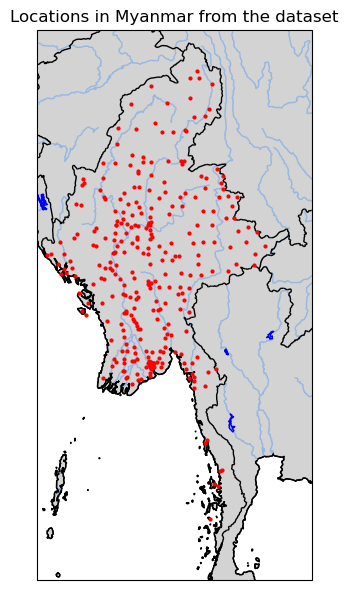

In [7]:
lon_min, lon_max = 92, 102  # Longitude range
lat_min, lat_max = 9, 29  # Latitude range

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
ax.add_feature(cfeature.LAKES, edgecolor="blue", facecolor="none")

for lat, lon, city in plot_locations:
    ax.plot(
        lon, lat, marker="o", color="red", markersize=2, transform=ccrs.PlateCarree()
    )

plt.title("Locations in Myanmar from the dataset")
plt.tight_layout()
plt.show();


In [8]:
dataset_locations = list(flood_df["Admin2"].unique())
location_flood_df = pd.DataFrame()

for location in tqdm(dataset_locations, desc="Processing locations", unit="location"):
    location_df = flood_df.loc[flood_df["Admin2"] == location]
    start_dates = location_df["Start_Date"].unique()

    for start_date in start_dates:
        end_dates = location_df.loc[location_df["Start_Date"] == start_date][
            "End_Date"
        ].unique()

        flooded_area, population_exposed = 0, 0

        for end_date in end_dates:
            temp_df = location_df.loc[
                (location_df["Start_Date"] == start_date)
                & (location_df["End_Date"] == end_date)
            ]
            new_flooded_area = temp_df["Flooded_Area_SqKM"].values[0]
            new_population_exposed = temp_df["Population_Exposed"].values[0]

            if np.isclose(flooded_area, new_flooded_area):
                continue

            location_flood_df = pd.concat(
                [
                    location_flood_df,
                    pd.DataFrame(
                        {
                            "Admin2": [temp_df["Admin2"].values[0]],
                            "Admin1": [temp_df["Admin1"].values[0]],
                            "Start_Date": [start_date],
                            "End_Date": [end_date],
                            "Date_Passed": [
                                (np.datetime64(end_date) - np.datetime64(start_date))
                                / np.timedelta64(1, "D")
                            ],
                            "Flooded_Area_SqKM": [new_flooded_area],
                            "Flood_Area_Difference": [
                                np.round(new_flooded_area - flooded_area, 4)
                                if flooded_area != 0
                                else 0
                            ],
                            "Population_Exposed": [new_population_exposed],
                            "Population_Exposed_Difference": [
                                np.round(new_population_exposed - population_exposed, 4)
                                if population_exposed != 0
                                else 0
                            ],
                        }
                    ),
                ],
                ignore_index=True,
            )
            flooded_area, population_exposed = new_flooded_area, new_population_exposed

location_flood_df.to_csv("location_flood_data.csv", index=False)
location_flood_df.head()

Processing locations:   0%|          | 0/80 [00:00<?, ?location/s]

Processing locations:   0%|          | 0/80 [00:02<?, ?location/s]


KeyboardInterrupt: 

In [ ]:
location_coords = {}

for location in tqdm(
    location_flood_df["Admin2"].unique(), desc="Fetching coordinates", unit="location"
):
    geo_location = geolocator.geocode(f"{location}, Myanmar")
    if geo_location:
        location_coords[location] = (geo_location.latitude, geo_location.longitude)
    else:
        location_coords[location] = np.nan

location_flood_df["Coordinates"] = location_flood_df["Admin2"].map(location_coords)
location_flood_df.to_csv("location_flood_data.csv", index=False)
location_flood_df.head(10)

Fetching coordinates:   0%|          | 0/80 [00:00<?, ?location/s]

Fetching coordinates: 100%|██████████| 80/80 [01:19<00:00,  1.01location/s]


,Admin2,Admin1,Start_Date,End_Date,Date_Passed,Flooded_Area_SqKM,Flood_Area_Difference,Population_Exposed,Population_Exposed_Difference,Coordinates
121,Yangon (West),Yangon,2024-07-06,2024-07-06,0.0,0.00,-0.03,0,-330.0,"(16.835843750000002, 96.13272557213965)"
201,Yangon (West),Yangon,2024-07-11,2024-08-15,35.0,0.02,0.01,225,88.0,"(16.835843750000002, 96.13272557213965)"
228,Yangon (West),Yangon,2024-07-11,2024-07-30,19.0,0.01,NaN,137,NaN,"(16.835843750000002, 96.13272557213965)"
295,Yangon (West),Yangon,2024-07-13,2024-08-15,33.0,0.02,0.01,225,88.0,"(16.835843750000002, 96.13272557213965)"
299,Yangon (West),Yangon,2024-07-13,2024-08-15,33.0,0.02,0.01,225,88.0,"(16.835843750000002, 96.13272557213965)"


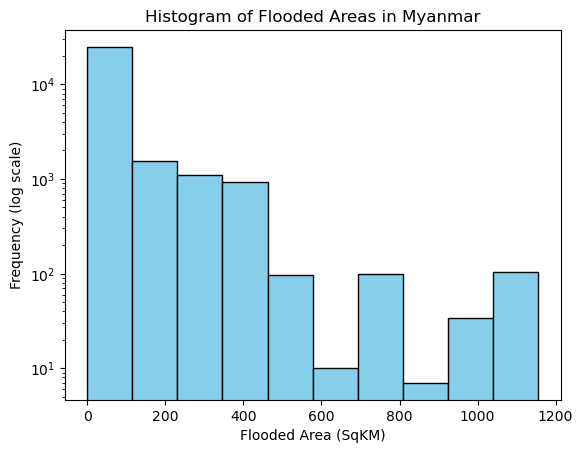

In [ ]:
location_flood_df = pd.read_csv("location_flood_data.csv")
flooded_areas = location_flood_df["Flooded_Area_SqKM"].values
flooded_areas = flooded_areas[~np.isnan(flooded_areas)]

plt.hist(flooded_areas, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Flooded Area (SqKM)")
# plt.yscale("log")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of Flooded Areas in Myanmar")
plt.show()


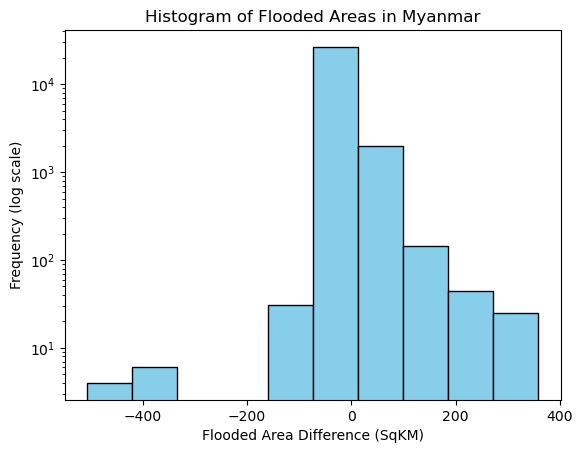

In [ ]:
flooded_areas = location_flood_df["Flood_Area_Difference"].values
flooded_areas = flooded_areas[~np.isnan(flooded_areas)]

plt.hist(flooded_areas, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Flooded Area Difference (SqKM)")
# plt.yscale("log")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of Flooded Areas in Myanmar")
plt.show()

In [ ]:
location_flood_df["Start_Date"] = pd.to_datetime(location_flood_df["Start_Date"])
location_flood_df["End_Date"] = pd.to_datetime(location_flood_df["End_Date"])

,Admin2,Admin1,Start_Date,End_Date,Date_Passed,Flooded_Area_SqKM,Flood_Area_Difference,Population_Exposed,Population_Exposed_Difference
0,Yangon (West),Yangon,2024-07-01,2024-07-30,29.0,0.01,0.00,137,0
1,Yangon (West),Yangon,2024-07-01,2024-08-15,45.0,0.02,0.01,225,88
2,Yangon (West),Yangon,2024-07-01,2024-09-28,89.0,0.03,0.01,330,105
3,Yangon (West),Yangon,2024-07-05,2024-07-30,25.0,0.01,0.00,137,0
4,Yangon (West),Yangon,2024-07-05,2024-08-15,41.0,0.02,0.01,225,88


In [23]:
location_flood_df.sort_values("Population_Exposed", ascending=False).head(10)

,Admin2,Admin1,Start_Date,End_Date,Date_Passed,Flooded_Area_SqKM,Flood_Area_Difference,Population_Exposed,Population_Exposed_Difference
3654,Pyapon,Ayeyarwady,2024-07-05,2024-10-26,113.0,1155.03,1.12,155214,121
3669,Pyapon,Ayeyarwady,2024-07-06,2024-10-26,112.0,1155.03,1.12,155214,121
3639,Pyapon,Ayeyarwady,2024-07-01,2024-10-26,117.0,1155.03,1.12,155214,121
3668,Pyapon,Ayeyarwady,2024-07-06,2024-10-22,108.0,1153.91,3.75,155093,425
3653,Pyapon,Ayeyarwady,2024-07-05,2024-10-22,109.0,1153.91,3.75,155093,425
3638,Pyapon,Ayeyarwady,2024-07-01,2024-10-22,113.0,1153.91,3.75,155093,425
3652,Pyapon,Ayeyarwady,2024-07-05,2024-09-28,85.0,1150.16,0.64,154668,92
3637,Pyapon,Ayeyarwady,2024-07-01,2024-09-28,89.0,1150.16,0.64,154668,92
3667,Pyapon,Ayeyarwady,2024-07-06,2024-09-28,84.0,1150.16,0.64,154668,92
3636,Pyapon,Ayeyarwady,2024-07-01,2024-09-20,81.0,1149.52,2.84,154576,295
